# Jupyter Notebook para el entrenamiento de modelos ML de Clasificación que determinen si un vuelo va a tener retraso o no

# Instalaciones

In [1]:
# %pip install imbalanced-learn
# !pip install --upgrade imbalanced-learn scikit-learn
# !pip install -U imbalanced-learn
# !pip install -U scikit-learn

# Importaciones

In [2]:
# Pre-requisites
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Store the classifier models to save time
import joblib

# Preprocessing
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split as tts
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

# Classifiers from scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import xgboost as xgb

# Performance metrics
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import precision_score as prec
from sklearn.metrics import recall_score as rec
from sklearn.metrics import f1_score as f1
from sklearn.metrics import confusion_matrix as cm


from sklearn.model_selection import GridSearchCV
from joblib import parallel_backend

In [3]:
fl = pd.read_csv("../data/ML/clean_data_for_ML.csv")

# Preparación de variables para el modelo

In [4]:
fl = fl[fl.duration.notna()]

In [5]:
fl.columns

Index(['arr_mins_of_delay', 'week_day', 'week_num', 'day_time',
       'cod_flight_IATA', 'cod_airliner_IATA', 'cod_airport_IATA', 'duration',
       'Temperature', 'Wind', 'acc_Gusts', 'Relative_hum', 'Pressure',
       'Condition', 'acc_bad_weather'],
      dtype='object')

## Elimino columnas de baja correlación o con demasiados valores que pueden provocar overfitting en los modelos

In [6]:
fl = fl.drop(columns = ['cod_flight_IATA','Relative_hum','Pressure','cod_airport_IATA'])

## Genero la variable target "Delayed"

In [7]:
fl['Delayed'] = fl['arr_mins_of_delay'].apply(lambda x: 1 if x > 0 else 0)

0    0.672649
1    0.327351
Name: Delayed, dtype: float64

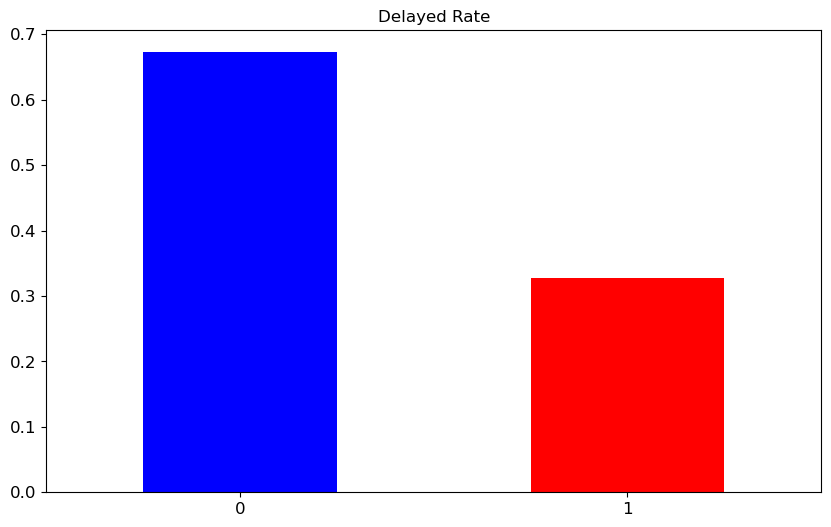

In [8]:
(fl.Delayed.value_counts()/len(fl)).plot.bar(color=['b', 'r'],    # plot customer churn rate
                                           figsize=(10, 6),
                                           title='Delayed Rate',
                                           rot=0,
                                           fontsize=12);


fl.Delayed.value_counts()/len(fl)

## Correlaciones

In [9]:
corr=fl.corr()   # correlation matrix

corr

C:\Users\daarr\AppData\Local\Temp\ipykernel_14204\3013328059.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr=fl.corr()   # correlation matrix


,arr_mins_of_delay,week_num,duration,Temperature,Wind,acc_Gusts,acc_bad_weather,Delayed
arr_mins_of_delay,1.000000,0.010288,-0.025159,0.051942,0.077659,0.082185,0.075111,0.621259
week_num,0.010288,1.000000,0.007501,0.178952,-0.036482,-0.010524,0.023384,0.016726
duration,-0.025159,0.007501,1.000000,0.032352,0.000747,-0.010846,-0.001045,0.040115
Temperature,0.051942,0.178952,0.032352,1.000000,0.148810,0.139241,-0.127939,0.065140
Wind,0.077659,-0.036482,0.000747,0.148810,1.000000,0.574136,0.043563,0.089730
acc_Gusts,0.082185,-0.010524,-0.010846,0.139241,0.574136,1.000000,0.023857,0.090510
acc_bad_weather,0.075111,0.023384,-0.001045,-0.127939,0.043563,0.023857,1.000000,0.063781
Delayed,0.621259,0.016726,0.040115,0.065140,0.089730,0.090510,0.063781,1.000000


## Cambio la columna week_num a categórica

In [10]:
fl['week_num'] = fl['week_num'].astype('object')

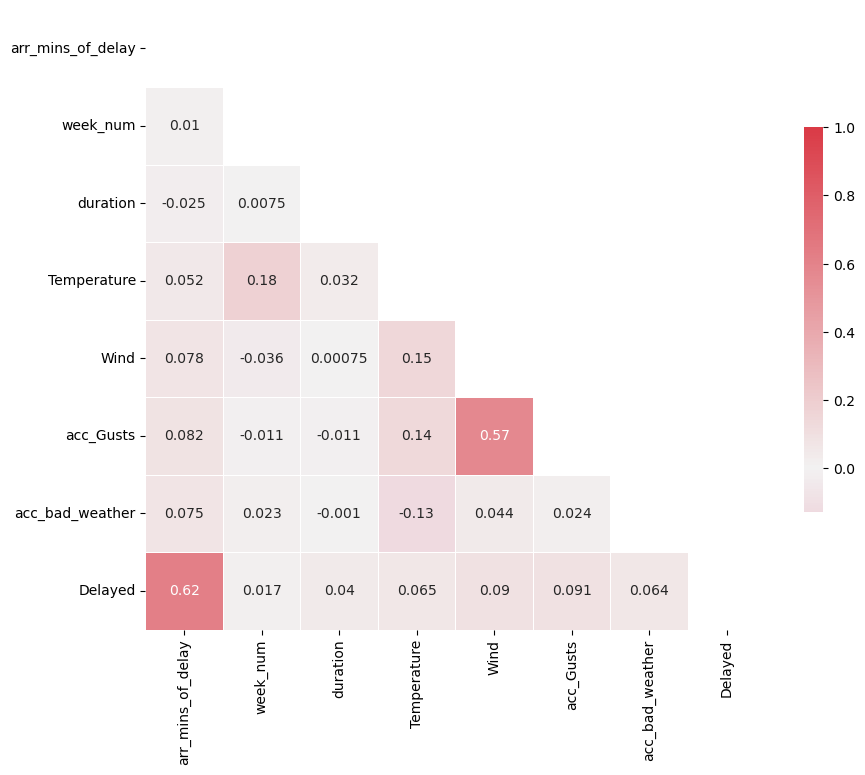

In [11]:
fig, ax=plt.subplots(figsize=(10,10))


mask=np.triu(np.ones_like(corr, dtype=bool))           # mask for superior triangular matrix


color_map=sns.diverging_palette(0, 10, as_cmap=True)   # color palette


# correlation heatmap
sns.heatmap(corr,                       # data
            mask=mask,                  # white mask
            cmap=color_map,             # color
            vmax=1,                     # vertical edge
            center=0,                   # plot center
            square=True,                # data square representation
            annot=True,
            linewidth=.5,               # linewidth
            cbar_kws={'shrink': .5},    # lateral bar legend
            ax=ax                       # axes for plot size
           );

In [12]:
fl = fl.drop(columns = ['arr_mins_of_delay'])

## One Hot Encoding

In [13]:
fl=pd.get_dummies(fl, columns = ['week_num','Condition','week_day','day_time','cod_airliner_IATA'], drop_first=True)


C:\Users\daarr\AppData\Local\Temp\ipykernel_14204\2196711668.py:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  fl=pd.get_dummies(fl, columns = ['week_num','Condition','week_day','day_time','cod_airliner_IATA'], drop_first=True)


In [14]:
fl.Delayed.value_counts()

0    592426
1    288310
Name: Delayed, dtype: int64

In [15]:
fl.shape

(880736, 184)

# División del DataFrame para el entrenamiento

In [16]:
X = fl.drop('Delayed', axis=1)
y = fl.Delayed

In [17]:
X.shape, y.shape

((880736, 183), (880736,))

In [18]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 880736 entries, 0 to 880761
Columns: 183 entries, duration to cod_airliner_IATA_YW
dtypes: float64(3), int64(2), uint8(178)
memory usage: 189.8 MB


In [19]:
# stratify mantiene la distribucion del objetivo
X_train, X_test, y_train, y_test = tts(X, y, 
                                       random_state=42,
                                       stratify=y)

# Normalización de las variables numéricas

In [20]:
escalador = StandardScaler()    # inicia el normalizador
 
X_train[['duration','Temperature', 'Wind', 'acc_Gusts','acc_bad_weather']] = escalador.fit_transform(X_train[['duration','Temperature', 'Wind', 'acc_Gusts','acc_bad_weather']])   # transforma train
X_test[['duration','Temperature', 'Wind', 'acc_Gusts','acc_bad_weather']] = escalador.transform(X_test[['duration','Temperature', 'Wind', 'acc_Gusts','acc_bad_weather']])  # transforma test

# Aplico SMOTE (Synthetic Minority over-sampling Technique) para equilibrar la diferencia entre clases

In [21]:
# # Aplicar SMOTE al conjunto de entrenamiento
# smote = SMOTE(sampling_strategy='auto', random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [22]:
X_train.shape

(660552, 183)

In [23]:
# X_resampled.shape

In [24]:
# Inicializar el objeto Tomek Links
tomek_links = TomekLinks(n_jobs = 8)

# Aplicar Tomek Links a los datos de entrenamiento
X_resampled, y_resampled = tomek_links.fit_resample(X_train, y_train)

In [25]:
X_resampled.shape

(633743, 183)

# Ensayo de diferentes modelos de regresión

# Logistic Regression

In [26]:
# logreg = LogisticRegression(n_jobs=8)


In [27]:
# logreg.fit(X_train, y_train)

In [28]:
# y_pred_logreg = logreg.predict(X_test)

# y_pred_logreg[:10]

In [29]:
# y_test.head(10)


In [30]:
# print("Score: ",logreg.score(X_test, y_test))
# print("Precission: ",prec(y_test, y_pred_logreg))
# print("Accuracy: ",acc(y_test, y_pred_logreg))
# print("Recall: ",rec(y_test, y_pred_logreg))
# print("F1: ",f1(y_test, y_pred_logreg))

In [31]:
# y_test.value_counts() / y_test.shape[0] * 100

In [32]:
# y_prob = logreg.predict_proba(X_test)
# y_prob[:10]

In [33]:
# y_pred_logreg2 = [1 if e[1]>0.3 else 0 for e in y_prob]

# sum(y_pred_logreg2==y_test) / len(y_pred_logreg2) * 100   # acierto, accuracy

In [34]:
# sum(y_pred_logreg2)

In [35]:
# cm(y_test, y_pred_logreg2)
# cm(y_test, y_pred_logreg2)/cm(y_test, y_pred_logreg2).sum()*100
# plt.figure(figsize=(15, 8))

# ax=sns.heatmap(cm(y_test, y_pred_logreg2)/cm(y_test, y_pred_logreg2).sum() * 100, 
#                annot=True)

# plt.title('Matriz confusion')
# plt.ylabel('Verdad')
# plt.xlabel('Prediccion')
# plt.show();

# XGBOOST

In [36]:
# xgbc = xgb.XGBClassifier(n_jobs = 8)

In [37]:
# xgbc.fit(X_train, y_train)

In [38]:
# y_pred_xgb = xgbc.predict(X_test)

# y_pred_xgb[:10]

In [39]:
# print("Score: ",xgbc.score(X_test, y_test))
# print("Precission: ",prec(y_test, y_pred_xgb))
# print("Accuracy: ",acc(y_test, y_pred_xgb))
# print("Recall: ",rec(y_test, y_pred_xgb))
# print("F1: ",f1(y_test, y_pred_xgb))

In [40]:
# y_prob = xgbc.predict_proba(X_test)

In [41]:
# y_prob[:10]

In [42]:
# y_test.head(10)

In [43]:
# y_pred_xgb.sum()

In [44]:
# cm(y_test, y_pred_xgb)
# cm(y_test, y_pred_xgb)/cm(y_test, y_pred_xgb).sum()*100
# plt.figure(figsize=(15, 8))

# ax=sns.heatmap(cm(y_test, y_pred_xgb)/cm(y_test, y_pred_xgb).sum() * 100, 
#                annot=True)

# plt.title('Matriz confusion')
# plt.ylabel('Verdad')
# plt.xlabel('Prediccion')

# RandomForestClassifier

In [45]:
rfc = RandomForestClassifier(n_estimators=200,
                             min_samples_split=5,
                             min_samples_leaf=2,
                             n_jobs=8)


In [46]:
rfc.fit(X_resampled, y_resampled)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, n_jobs=8)

In [47]:
y_pred_rfc = rfc.predict(X_test)

y_pred_rfc[:10]

array([0, 0, 1, 0, 1, 0, 0, 0, 1, 0], dtype=int64)

In [48]:
print("Score: ",rfc.score(X_test, y_test))
print("Precission: ",prec(y_test, y_pred_rfc))
print("Accuracy: ",acc(y_test, y_pred_rfc))
print("Recall: ",rec(y_test, y_pred_rfc))
print("F1: ",f1(y_test, y_pred_rfc))

Score:  0.7062229771463867
Precission:  0.5832432432432433
Accuracy:  0.7062229771463867
Recall:  0.3592824340635709
F1:  0.44465430943448064


In [49]:
y_prob = rfc.predict_proba(X_test)

In [50]:
y_test.head(10)

50135     0
307634    0
103637    1
508712    0
72626     1
662607    0
806215    0
593930    0
459207    1
227302    0
Name: Delayed, dtype: int64

In [51]:
y_prob[:10]

array([[0.67605857, 0.32394143],
       [0.67317006, 0.32682994],
       [0.40432298, 0.59567702],
       [0.56226171, 0.43773829],
       [0.4100481 , 0.5899519 ],
       [0.75116827, 0.24883173],
       [0.83777773, 0.16222227],
       [0.8123261 , 0.1876739 ],
       [0.36127126, 0.63872874],
       [0.85178442, 0.14821558]])

In [52]:
print(sum(y_pred_rfc))
print(sum(y_test))

44400
72077


# Cambio el umbral de decisión para aumentar el recall

In [76]:
y_pred_rfc2 = [1 if e[1]>0.28 else 0 for e in y_prob]

In [77]:
sum(y_pred_rfc2)

132343

In [78]:
print("Precission: ",prec(y_test, y_pred_rfc2))
print("Accuracy: ",acc(y_test, y_pred_rfc2))
print("Recall: ",rec(y_test, y_pred_rfc2))
print("F1: ",f1(y_test, y_pred_rfc2))

Precission:  0.42227393968702537
Accuracy:  0.5792155651636813
Recall:  0.775351360350736
F1:  0.5467664612073182


In [79]:
sum(y_pred_rfc2)/len(y_pred_rfc2)

0.6010563892017585

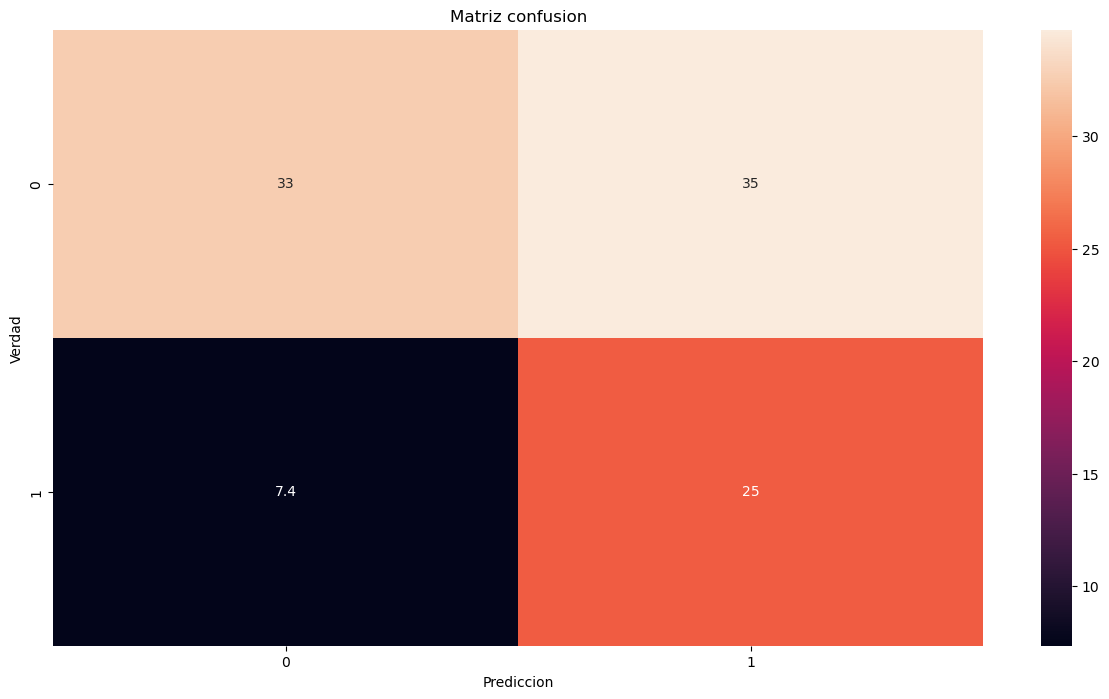

In [80]:
cm(y_test, y_pred_rfc2)
cm(y_test, y_pred_rfc2)/cm(y_test, y_pred_rfc2).sum()*100
plt.figure(figsize=(15, 8))

ax=sns.heatmap(cm(y_test, y_pred_rfc2)/cm(y_test, y_pred_rfc2).sum() * 100, 
               annot=True)

plt.title('Matriz confusion')
plt.ylabel('Verdad')
plt.xlabel('Prediccion')
plt.show();

Text(0.5, 58.7222222222222, 'Prediccion')

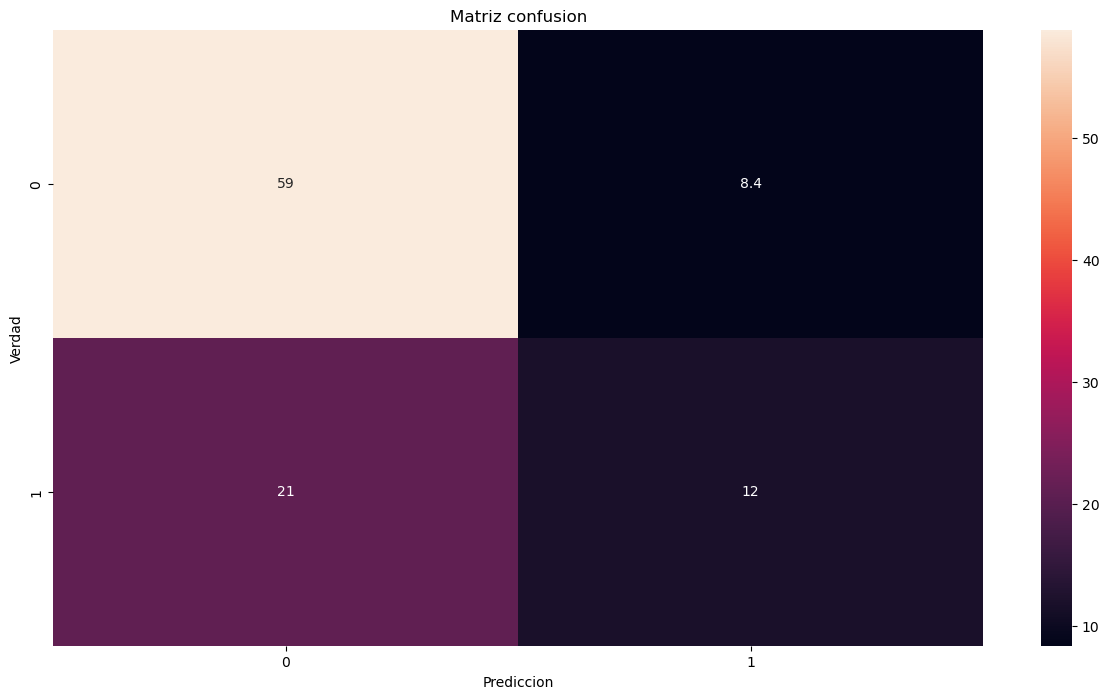

In [58]:
cm(y_test, y_pred_rfc)
cm(y_test, y_pred_rfc)/cm(y_test, y_pred_rfc).sum()*100
plt.figure(figsize=(15, 8))

ax=sns.heatmap(cm(y_test, y_pred_rfc)/cm(y_test, y_pred_rfc).sum() * 100, 
               annot=True)

plt.title('Matriz confusion')
plt.ylabel('Verdad')
plt.xlabel('Prediccion')

# Busqueda de Hiperparámetros

In [59]:
# # Crear el clasificador RandomForestClassifier
# rfc = RandomForestClassifier(n_jobs=4, random_state=42)

# # Definir los parámetros que deseas ajustar
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Crear el objeto GridSearchCV
# grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='recall', n_jobs=2)

# # Ajustar el modelo a los datos
# grid_search.fit(X_resampled, y_resampled)

# # Imprimir los mejores hiperparámetros encontrados
# print("Mejores hiperparámetros:", grid_search.best_params_)

# # Imprimir la precisión del mejor modelo en el conjunto de prueba
# print("Precisión en el conjunto de prueba:", grid_search.best_estimator_.score(X_test, y_test))